# Interactions and varying intercepts in a Poisson GLM

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import time

In [2]:
tic = time.time()

### Overview

This example is derived from an exercise in *Statistical Rethinking*, 2nd ed., by Richard McElreath.

The following data set comes from a survey of 47 plots of Northern California forest land. The survey is intended to count salamanders in each plot, and determine the effect of the physical properties of the forest on the presence of salamanders. The data set is below; the outcome variable `SALAMAN` is the number of salamanders counted in each plot. `PCTCOVER` is the percentage of ground covered by plants, and `FORESTAGE` is the average age of trees in the plot. We scale both variables; the percentage is scaled to a proportion scale (0 to 1) and the forest age is standardized.

In [3]:
salamanders = pd.read_csv('../../data/salamanders.csv', sep=';', index_col = 0)
salamanders['PCTCOVER'] = salamanders['PCTCOVER'] / 100
salamanders['FORESTAGE'] = (salamanders['FORESTAGE'] - salamanders['FORESTAGE'].mean()) / salamanders['FORESTAGE'].std()
salamanders.head()

,SALAMAN,PCTCOVER,FORESTAGE
SITE,,,
1,13,0.85,0.760627
2,11,0.86,-0.417586
3,11,0.90,1.959512
4,9,0.88,-0.541609
5,8,0.89,-0.650129


A simple DAG for the relationship between age, coverage, and salamanders suggests that forest age is a potential "fork" confound -- forest age presumably influences ground cover (positively), and may conceivably influence the presence of salamanders (direction unclear). So, our initial model conditions on age to block this confound.

The model is a simple Poisson GLM with log link:
$$
\begin{align*}
y_i &\sim \mathrm{Poisson}(\lambda_i) \\
\log \lambda_i &= \alpha + \beta_A A_i + \beta_C C_i \\
\alpha &\sim \mathrm{Normal}(0, 1) \\
\beta_A &\sim \mathrm{Normal}(0, 1) \\
\beta_C &\sim \mathrm{Normal}(0, 1) 
\end{align*}
$$

In [4]:
with pm.Model() as age_model:
    alpha = pm.Normal('alpha', 0, 1)
    bcov = pm.Normal('bcov', 0, 1)
    bage = pm.Normal('bage', 0, 1)
    
    rate = pm.Deterministic('rate', 
                            pm.math.exp(alpha 
                                        + bage * salamanders['FORESTAGE']
                                        + bcov * salamanders['PCTCOVER']))
    
    y_ = pm.Poisson('y', rate, observed = salamanders['SALAMAN'])
    age_trace = pm.sample()
    rate_summary = az.summary(age_trace, var_names = ['rate'])  # Summary including rates per plot
    coef_summary = az.summary(age_trace, var_names = ['alpha', 'bcov', 'bage']) # Only the model coefficients
    age_repl = pm.sample_posterior_predictive(age_trace)

<ipython-input-4-0f6a71d2041c>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  age_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bage, bcov, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [5]:
coef_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.856,0.330,-1.458,-0.214,0.009,0.006,1329.0,1798.0,1.0
bcov,2.441,0.416,1.703,3.278,0.012,0.008,1300.0,1788.0,1.0
bage,0.049,0.098,-0.135,0.228,0.002,0.002,1605.0,1629.0,1.0


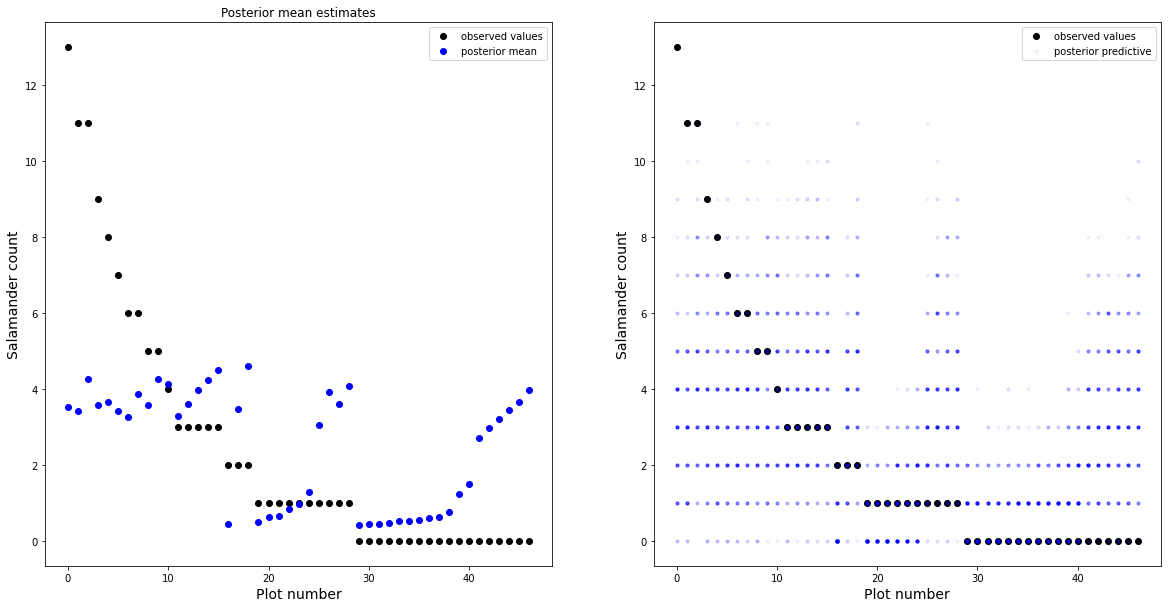

In [6]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

# Plot posterior means
axs[0].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
axs[0].plot(range(47), rate_summary['mean'], 'bo', label = 'posterior mean')
axs[0].set_title('Posterior mean estimates')
axs[0].legend()
axs[0].set_ylabel('Salamander count', size=14)
axs[0].set_xlabel('Plot number', size=14)

# Plot posterior predictive samples
axs[1].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
for i in range(100):
    axs[1].plot(range(47), age_repl['y'][i, :], 'b.', alpha = 0.05)
axs[1].plot(range(47), age_repl['y'][101, :], 'b.', alpha = 0.05, label = 'posterior predictive')
axs[1].set_ylabel('Salamander count', size=14)
axs[1].set_xlabel('Plot number', size=14)
axs[1].legend()

plt.show()

The point estimates and posterior predictions are way off the observed data. As a result, we can't really trust these coefficient estimates. One thing we could add to the model is an interaction between cover and age. It's a long shot that this will fix all of the predictive problems, but it may reveal some interesting features. The new model is:

$$
\begin{align*}
y_i &\sim \mathrm{Poisson}(\lambda_i) \\
\log \lambda_i &= \alpha + \beta_A A_i + \beta_C C_i + \beta_{A, C} A_i C_i \\
\alpha &\sim \mathrm{Normal}(0, 1) \\
\beta_A &\sim \mathrm{Normal}(0, 1) \\
\beta_C &\sim \mathrm{Normal}(0, 1) \\
\beta_{A, C} &\sim \mathrm{Normal}(0, 0.5)
\end{align*}
$$

In [7]:
with pm.Model() as interaction_model:
    alpha = pm.Normal('alpha', 0, 1)
    bcov = pm.Normal('bcov', 0, 1)
    bage = pm.Normal('bage', 0, 1)
    bint = pm.Normal('bint', 0, 0.5)
    
    rate = pm.Deterministic('rate', 
                            pm.math.exp(alpha 
                                        + bcov * salamanders['PCTCOVER'] 
                                        + bage * salamanders['FORESTAGE']
                                        + bint * salamanders['PCTCOVER'] * salamanders['FORESTAGE']))
    
    y_ = pm.Poisson('y', rate, observed = salamanders['SALAMAN'])
    int_trace = pm.sample(target_accept = 0.95)
    rate_summary = az.summary(int_trace, var_names = ['rate'])
    coef_summary = az.summary(int_trace, var_names = ['alpha', 'bcov', 'bage', 'bint'])
    int_repl = pm.sample_posterior_predictive(int_trace)

<ipython-input-7-96975ac7ad8d>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  int_trace = pm.sample(target_accept = 0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bint, bage, bcov, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [8]:
coef_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.714,0.361,-1.442,-0.075,0.010,0.007,1225.0,1524.0,1.01
bcov,2.290,0.438,1.465,3.125,0.012,0.009,1250.0,1536.0,1.01
bage,0.332,0.345,-0.272,1.041,0.010,0.007,1140.0,1218.0,1.00
bint,-0.330,0.388,-1.090,0.368,0.011,0.008,1142.0,1205.0,1.00


As we see below, this hasn't improved the problem with the posterior estimates. But the interaction slope is interesting. We note that it is approximately equal and opposite to the slope of `FORESTAGE`. Since `PCTCOVER` is on a scale from 0 to 1, we can try to interpret this by considering the endpoints `PCTCOVER = 0` and `PCTCOVER = 1`. When ground coverage is zero, the interaction has no effect; when ground coverage is 1, the interaction cancels the effect of age. In other words, for plots where coverage is high, the local age of trees does not carry useful information for predicting salamanders; for plots where coverage is low, the age of trees is positively associated with salamanders.

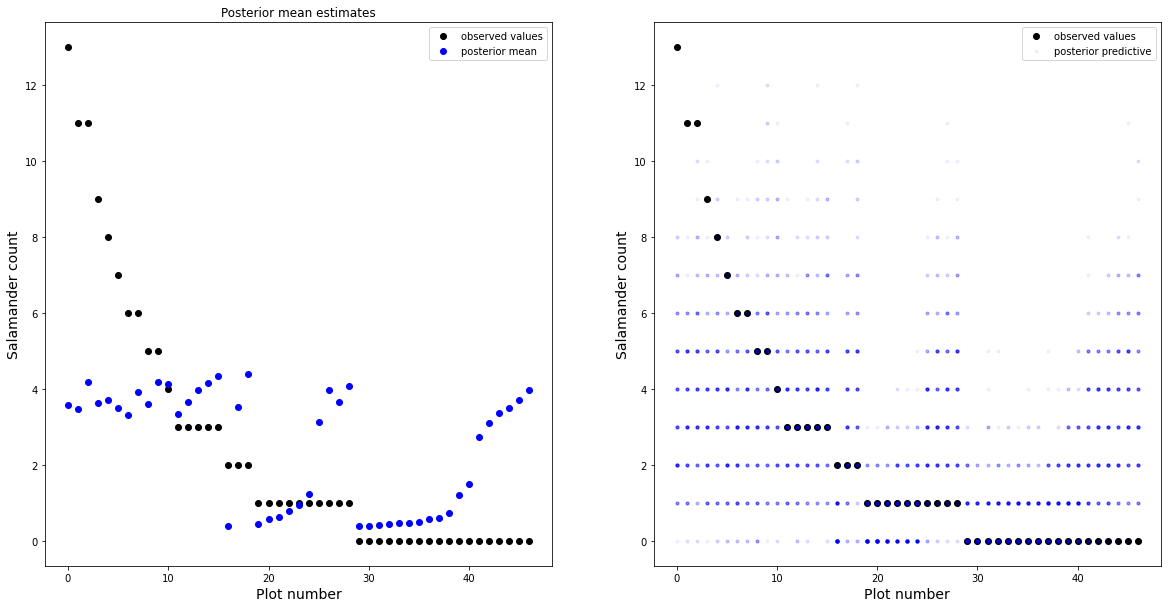

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

# Plot posterior means
axs[0].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
axs[0].plot(range(47), rate_summary['mean'], 'bo', label = 'posterior mean')
axs[0].set_title('Posterior mean estimates')
axs[0].legend()
axs[0].set_ylabel('Salamander count', size=14)
axs[0].set_xlabel('Plot number', size=14)

# Plot posterior predictive samples
axs[1].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
for i in range(100):
    axs[1].plot(range(47), int_repl['y'][i, :], 'b.', alpha = 0.05)
axs[1].plot(range(47), int_repl['y'][101, :], 'b.', alpha = 0.05, label = 'posterior predictive')
axs[1].set_ylabel('Salamander count', size=14)
axs[1].set_xlabel('Plot number', size=14)
axs[1].legend()

plt.show()

To help understand this interaction, it is useful to visualize the relationship between forest age and ground cover.

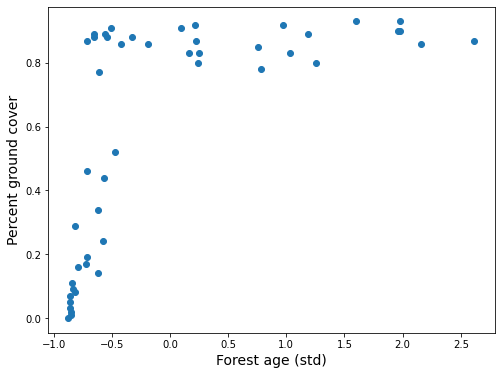

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(salamanders['FORESTAGE'], salamanders['PCTCOVER'], 'o')
plt.xlabel('Forest age (std)', size=14)
plt.ylabel('Percent ground cover', size=14)
plt.show()

The forest plots split into two clusters. One cluster has consistently high coverage (80-90%) and no apparent association between forest age and coverage. The other cluster has lower coverage, low age, and a clear positive association between these two variables. A natural hypothesis is that the first cluster consists of locations that have reached an ecological steady state, while in the second cluster the forest is in active growth. Although the cause for this is not stated in the data, a plausible explanation is that the plots in the second cluster have recently burned in wildfires (remember, this is Northern California!) and are in the process of recovering.

This is somewhat ad-hoc, but the clusters are clear enough that we can assign cluster membership by hand. This allows us to split the model into two, conditional on cluster membership, which may illuminate the nature of this interaction.

In [11]:
burned = (salamanders['PCTCOVER'] < 0.7).astype(np.int64)

In [12]:
with pm.Model() as full_interaction_model:
    alpha = pm.Normal('alpha', 0, 1, shape=2)
    bcov = pm.Normal('bcov', 0, 1, shape=2)
    bage = pm.Normal('bage', 0, 1, shape=2)
    bint = pm.Normal('bint', 0, 0.5, shape=2)
    
    rate = pm.Deterministic('rate', 
                            pm.math.exp(alpha[burned] 
                                        + bcov[burned] * salamanders['PCTCOVER'] 
                                        + bage[burned] * salamanders['FORESTAGE']
                                        + bint[burned] * salamanders['PCTCOVER'] * salamanders['FORESTAGE']))
    
    y_ = pm.Poisson('y', rate, observed = salamanders['SALAMAN'])
    full_int_trace = pm.sample(target_accept = 0.95)
    rate_summary = az.summary(full_int_trace, var_names = ['rate'])
    coef_summary = az.summary(full_int_trace, var_names = ['alpha', 'bcov', 'bage', 'bint'])
    full_int_repl = pm.sample_posterior_predictive(full_int_trace)

<ipython-input-12-a11e4ba40dbc>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  full_int_trace = pm.sample(target_accept = 0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bint, bage, bcov, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [13]:
coef_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.496,0.627,-0.670,1.605,0.013,0.010,2419.0,2075.0,1.0
alpha[1],-0.654,0.636,-1.806,0.542,0.013,0.009,2547.0,2216.0,1.0
bcov[0],0.962,0.721,-0.305,2.330,0.015,0.011,2369.0,1966.0,1.0
bcov[1],-0.031,0.896,-1.668,1.694,0.015,0.014,3636.0,2642.0,1.0
bage[0],-0.020,0.408,-0.764,0.759,0.008,0.007,2433.0,2308.0,1.0
bage[1],0.269,0.785,-1.144,1.709,0.015,0.013,2718.0,2546.0,1.0
bint[0],0.029,0.451,-0.799,0.874,0.009,0.008,2411.0,2355.0,1.0
bint[1],-0.022,0.495,-1.005,0.859,0.008,0.008,4034.0,2547.0,1.0


First, we note that splitting the data has resulted in reduced precision for all estimates, so no especially strong conclusions can be drawn here -- but, the results of this regression are consistent with the results and intuition we developed previously. The baseline rate is much lower for the burned plots. Furthermore, in unburned plots, coverage has a strong association with salamanders and age is nearly irrelevant; in burned plots, age has a positive association, but coverage is (conditional on age) mostly irrelevant.

Finally, the interaction term has been reduced to nearly zero, suggesting that the interaction effect estimated before was really estimating the interaction between burned status and the effects of age and coverage.

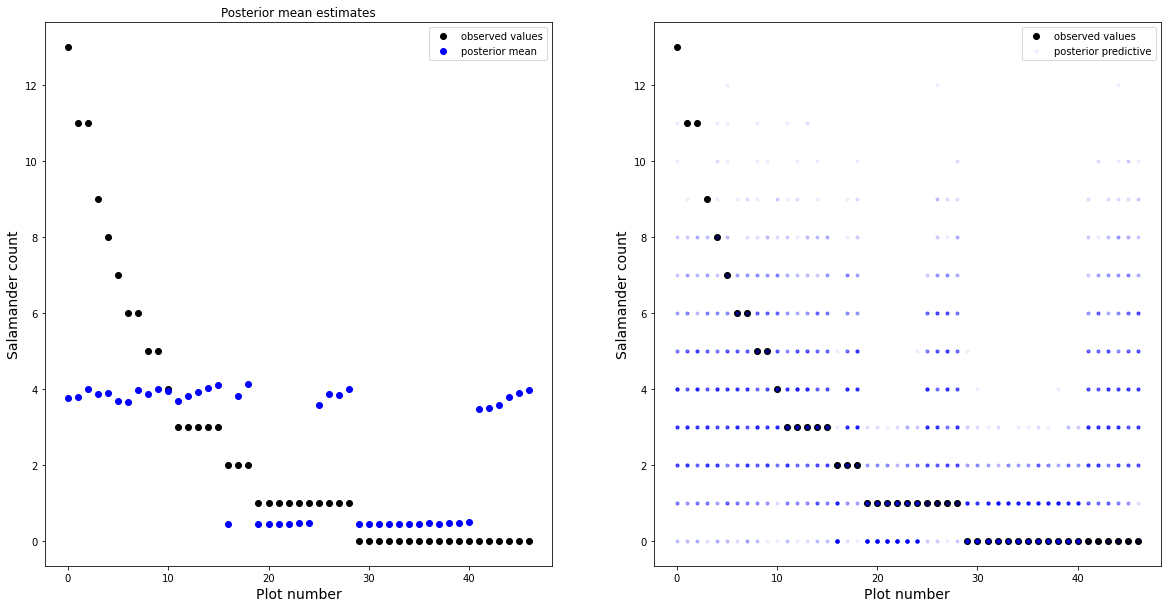

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

# Plot posterior means
axs[0].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
axs[0].plot(range(47), rate_summary['mean'], 'bo', label = 'posterior mean')
axs[0].set_title('Posterior mean estimates')
axs[0].legend()
axs[0].set_ylabel('Salamander count', size=14)
axs[0].set_xlabel('Plot number', size=14)

# Plot posterior predictive samples
axs[1].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
for i in range(100):
    axs[1].plot(range(47), full_int_repl['y'][i, :], 'b.', alpha = 0.05)
axs[1].plot(range(47), full_int_repl['y'][101, :], 'b.', alpha = 0.05, label = 'posterior predictive')
axs[1].set_ylabel('Salamander count', size=14)
axs[1].set_xlabel('Plot number', size=14)
axs[1].legend()

plt.show()

### Varying intercepts

However, even with this more elaborate model, the fit to data is poor. Having exhausted all ideas and combinations of predictors, we must conclude that there is additional variation in the data that cannot be modeled by a pure Poisson regression based on the available variables. This is known as "overdispersion" -- since the Poisson distribution has variance equal to its mean, it is limited in its ability to model variation because the variance cannot be fit independently of the mean. To account for this, we turn to a **varying-intercepts** model, where each plot is given its own value of $\alpha$. Additional variation will be accounted for by these intercepts, which should improve the fit to data and also improve the accuracy of the coefficient estimates (since the slope coefficients no longer have to account for all the variation in the observed values).

We begin with a simple version of the model, going back to our original GLM, only with 47 intercepts and a multilevel structure to regularize them.

$$
\begin{align*}
y_i &\sim \mathrm{Poisson}(\lambda_i) \\
\log \lambda_i &= \alpha_i + \beta_A A_i + \beta_C C_i + \beta_{A, C} A_i C_i \\
\alpha_i &\sim \mathrm{Normal}(\mu, \sigma) \\
\beta_A &\sim \mathrm{Normal}(0, 1) \\
\beta_C &\sim \mathrm{Normal}(0, 1) \\
\mu &\sim \mathrm{Normal}(0, 1) \\
\sigma &\sim \mathrm{Exponential}(1)
\end{align*}
$$

In [15]:
with pm.Model() as varying_intercept:
    # Hyperparameters
    mu = pm.Normal('mu', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    
    # Varying intercepts, single slopes
    alpha = pm.Normal('alpha', mu, sigma, shape = 47)
    bcov = pm.Normal('bcov', 0, 1)
    bage = pm.Normal('bage', 0, 1)
    
    rate = pm.Deterministic('rate', 
                            pm.math.exp(alpha 
                                        + bcov * salamanders['PCTCOVER'] 
                                        + bage * salamanders['FORESTAGE']))
    
    y_ = pm.Poisson('y', rate, observed = salamanders['SALAMAN'])
    varint_trace = pm.sample(target_accept = 0.95)
    rate_summary = az.summary(varint_trace, var_names = ['rate'])
    coef_summary = az.summary(varint_trace, var_names = ['mu', 'sigma', 'bcov', 'bage'])
    varint_repl = pm.sample_posterior_predictive(varint_trace)

<ipython-input-15-07b537528d58>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  varint_trace = pm.sample(target_accept = 0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bage, bcov, alpha, sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [16]:
coef_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.841,0.412,-1.645,-0.111,0.019,0.014,461.0,893.0,1.0
sigma,0.999,0.215,0.611,1.400,0.008,0.006,647.0,1183.0,1.0
bcov,1.734,0.582,0.679,2.782,0.030,0.021,387.0,829.0,1.0
bage,0.241,0.215,-0.164,0.636,0.007,0.005,1102.0,1467.0,1.0


Immediately, we see that the fit to data is better (below) and also that the slope estimates are smaller -- because the slopes no longer have to try to explain all of the variation, as some of that is taken up by the flexibility of the $alpha_i$s.

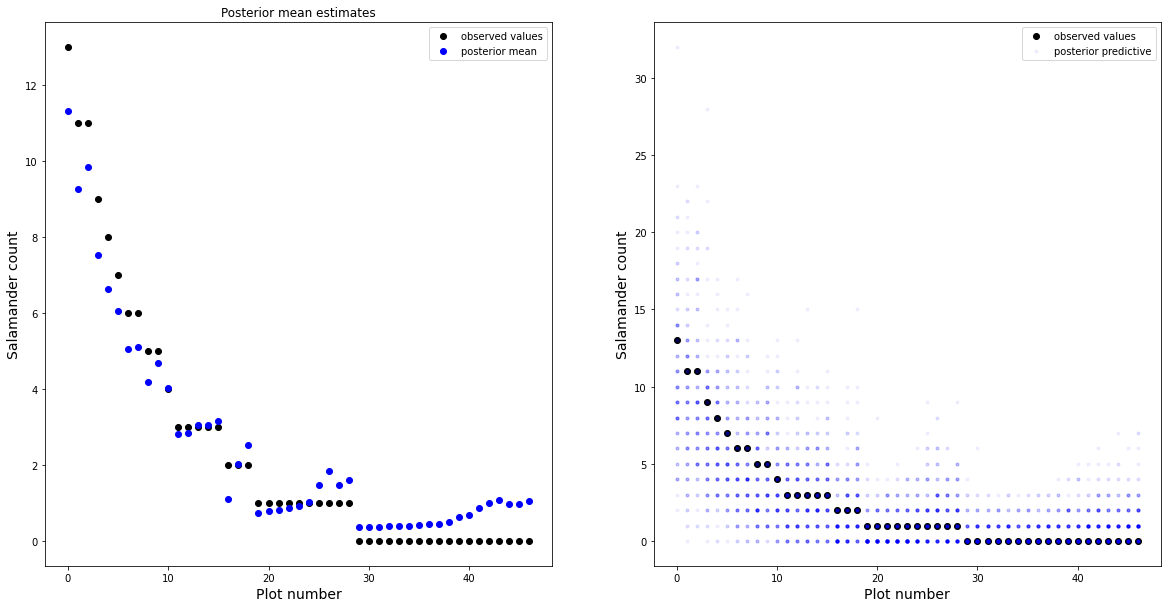

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

# Plot posterior means
axs[0].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
axs[0].plot(range(47), rate_summary['mean'], 'bo', label = 'posterior mean')
axs[0].set_title('Posterior mean estimates')
axs[0].legend()
axs[0].set_ylabel('Salamander count', size=14)
axs[0].set_xlabel('Plot number', size=14)

# Plot posterior predictive samples
axs[1].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
for i in range(100):
    axs[1].plot(range(47), varint_repl['y'][i, :], 'b.', alpha = 0.05)
axs[1].plot(range(47), varint_repl['y'][101, :], 'b.', alpha = 0.05, label = 'posterior predictive')
axs[1].set_ylabel('Salamander count', size=14)
axs[1].set_xlabel('Plot number', size=14)
axs[1].legend()

plt.show()

Finally, we return to the model conditional on burned status, but with varying intercepts. (Note we drop the explicit interaction term, having found it to be negligible in the previous model).

In [18]:
with pm.Model() as everything_model:
    mu = pm.Normal('mu', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu, sigma, shape = 47)
    bcov = pm.Normal('bcov', 0, 1, shape = 2)
    bage = pm.Normal('bage', 0, 1, shape = 2)
    
    rate = pm.Deterministic('rate', 
                            pm.math.exp(alpha 
                                        + bcov[burned] * salamanders['PCTCOVER'] 
                                        + bage[burned] * salamanders['FORESTAGE']))
    
    y_ = pm.Poisson('y', rate, observed = salamanders['SALAMAN'])
    everything_trace = pm.sample(2000, target_accept = 0.95)
    rate_summary = az.summary(everything_trace, var_names = ['rate'])
    coef_summary = az.summary(everything_trace, var_names = ['mu', 'sigma', 'bcov', 'bage'])
    everything_repl = pm.sample_posterior_predictive(everything_trace)

<ipython-input-18-c9acb2c0a0ae>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  everything_trace = pm.sample(2000, target_accept = 0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bage, bcov, alpha, sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [19]:
coef_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.249,0.530,-1.239,0.756,0.024,0.017,472.0,991.0,1.0
sigma,0.961,0.207,0.581,1.343,0.005,0.004,1565.0,2593.0,1.0
bcov[0],1.266,0.620,0.074,2.421,0.028,0.020,478.0,1051.0,1.0
bcov[1],-0.239,0.917,-2.002,1.450,0.012,0.010,5647.0,5249.0,1.0
bage[0],0.077,0.215,-0.334,0.477,0.003,0.002,3888.0,4749.0,1.0
bage[1],0.968,0.710,-0.381,2.287,0.024,0.017,891.0,2088.0,1.0


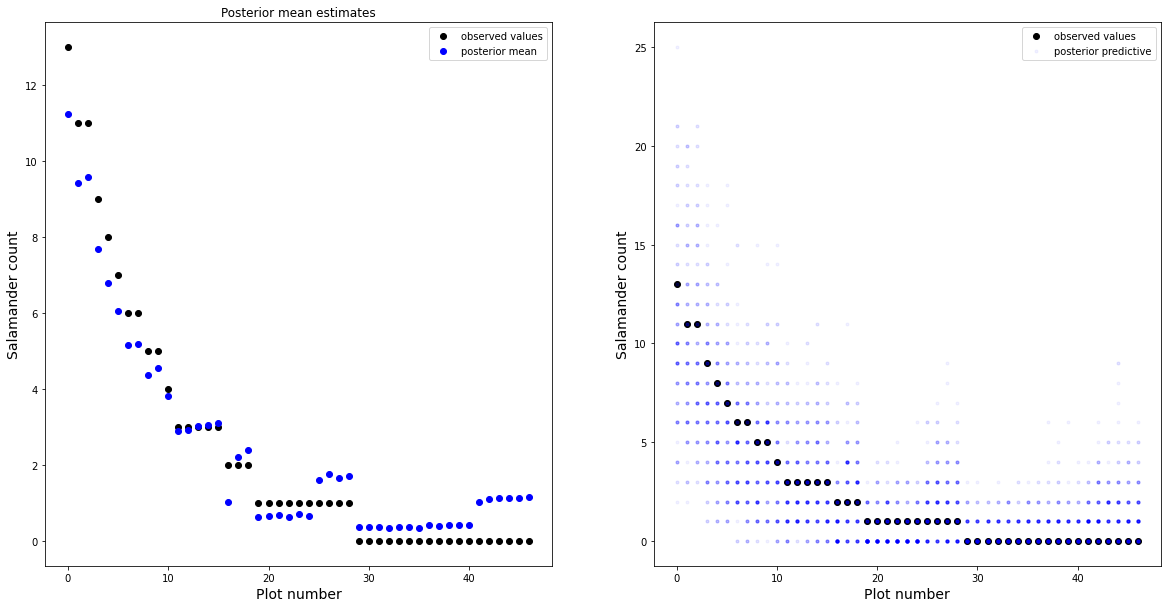

In [20]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

# Plot posterior means
axs[0].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
axs[0].plot(range(47), rate_summary['mean'], 'bo', label = 'posterior mean')
axs[0].set_title('Posterior mean estimates')
axs[0].legend()
axs[0].set_ylabel('Salamander count', size=14)
axs[0].set_xlabel('Plot number', size=14)

# Plot posterior predictive samples
axs[1].plot(range(47), salamanders['SALAMAN'], 'ko', label = 'observed values')
for i in range(100):
    axs[1].plot(range(47), everything_repl['y'][i, :], 'b.', alpha = 0.05)
axs[1].plot(range(47), everything_repl['y'][101, :], 'b.', alpha = 0.05, label = 'posterior predictive')
axs[1].set_ylabel('Salamander count', size=14)
axs[1].set_xlabel('Plot number', size=14)
axs[1].legend()

plt.show()

In [21]:
az.compare({'simple reg':age_trace,
            'interactions': int_trace,
            'full interactions':full_int_trace,
            'varying intercepts':varint_trace,
            'varying intercepts, interactions':everything_trace})

/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
"varying intercepts, interactions",0,-83.852707,22.339507,0.000000,1.000000e+00,6.868303,0.000000,True,log
varying intercepts,1,-84.800413,23.522616,0.947706,2.220446e-16,7.170724,1.113975,True,log
full interactions,2,-108.983702,7.884328,25.130995,1.325580e-15,13.297003,8.928571,False,log
interactions,3,-109.369162,7.095083,25.516455,5.525692e-16,13.464902,9.089297,False,log
simple reg,4,-109.682049,7.322049,25.829342,0.000000e+00,13.559666,9.170669,False,log


In [22]:
az.compare({'simple reg':age_trace,
            'interactions': int_trace,
            'full interactions':full_int_trace,
            'varying intercepts':varint_trace,
            'varying intercepts, interactions':everything_trace},
            ic='waic')

/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` w

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
"varying intercepts, interactions",0,-78.258715,16.745516,0.000000,7.030190e-01,6.133258,0.000000,True,log
varying intercepts,1,-78.417935,17.140138,0.159220,2.969810e-01,6.214914,0.883925,True,log
full interactions,2,-108.900247,7.800873,30.641532,0.000000e+00,13.276988,9.545215,True,log
interactions,3,-109.309563,7.035484,31.050848,0.000000e+00,13.447743,9.718596,True,log
simple reg,4,-109.608696,7.248697,31.349981,2.331468e-15,13.534142,9.794497,True,log


In [23]:
toc = time.time()
print('Notebook ran in', round(toc - tic), 'seconds.')
print('PyMC3 version', pm.__version__)
print('ArviZ version', az.__version__)
print('NumPy version', np.__version__)

Notebook ran in 100 seconds.
PyMC3 version 3.11.2
ArviZ version 0.11.2
NumPy version 1.21.0
